# Tutorial 9.5

## template fitting mock data test (B mode)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullvar = dict()
fullvar[95] = vmap95
fullvar[150] = vmap150

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f
tmpmap[353] = map353f

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### run `preprocess` to get covariance matrix M and noise average

In [2]:
%%time

FREQS = [95.,150.]
TARGET = 'B'

pipeline = af.tpfpipe(fullmap,mask=mask,variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,
                      foreground=syncdustmodel,background=cambmodel,
                      target=TARGET)

NSAMP = 30
APOSCALE = 6.
PSBIN = 40
LMIN = 50
LMAX = 200

pipeline.debug=False
inter = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=NSAMP)

CPU times: user 36min 46s, sys: 3.02 s, total: 36min 49s
Wall time: 4min 44s


#### run `analyse` to apply Bayesian sampler

iter: 7314 | +1000 | bound: 10 | nc: 1 | ncall: 50043 | eff(%): 16.614 | loglstar:   -inf < -3.135 <    inf | logz: -10.327 +/-  0.121 | dlogz:  0.001 >  1.009                                       

Removed no burn in


iter: 6262 | +1000 | bound: 6 | nc: 1 | ncall: 45137 | eff(%): 16.089 | loglstar:   -inf < -2.740 <    inf | logz: -8.871 +/-  0.114 | dlogz:  0.001 >  1.009                                         

Removed no burn in


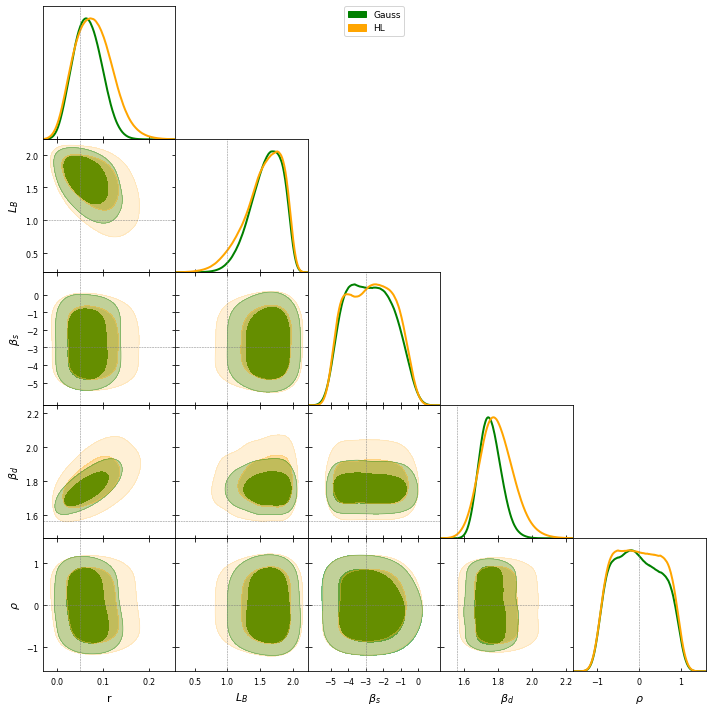

In [3]:
names = [r'r',r'$L_B$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']
truths = [0.05,1.,-3.,1.56,0.]
KWARGS = {'nlive':1000}
pipeline.param_range = {'r':[0,0.5]}

pipeline.likelihood='gauss'
result1 = pipeline.analyse(inter[0],inter[1],inter[2],inter[3],kwargs=KWARGS)
samples, weights = result1.samples, np.exp(result1.logwt - result1.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result2 = pipeline.analyse(inter[0],inter[1],inter[2],inter[3],kwargs=KWARGS)
samples, weights = result2.samples, np.exp(result2.logwt - result2.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### process new measurements with `reprocess`, run Bayesian analysis again

iter: 6464 | +1000 | bound: 7 | nc: 1 | ncall: 44846 | eff(%): 16.644 | loglstar:   -inf < -1.588 <    inf | logz: -8.048 +/-  0.120 | dlogz:  0.001 >  1.009                                         

Removed no burn in
Removed no burn in
CPU times: user 59min 16s, sys: 1min 31s, total: 1h 47s
Wall time: 42min 3s


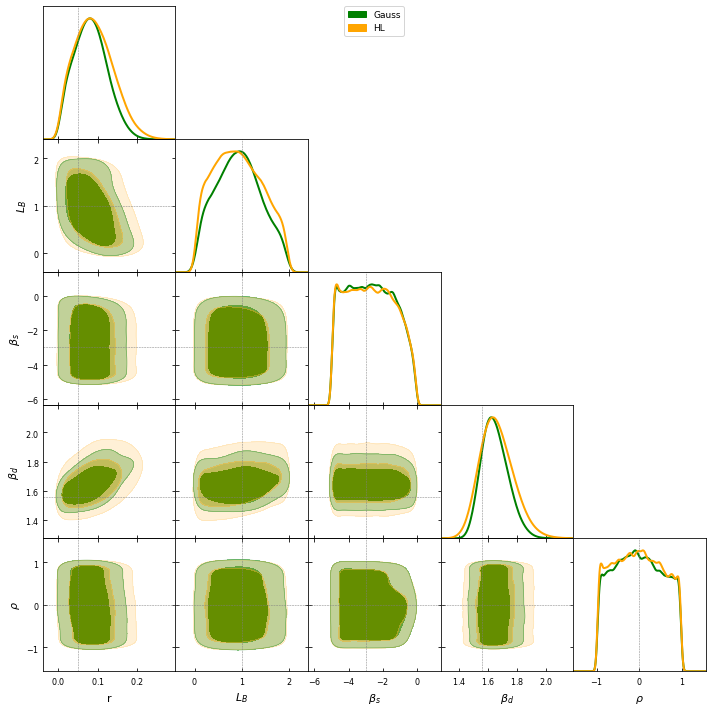

In [4]:
%%time
# re-run the analysis many times
rerun = 20

samples_g, weights_g = result1.samples, np.exp(result1.logwt - result1.logz[-1])
samples_h, weights_h = result2.samples, np.exp(result2.logwt - result2.logz[-1])

for i in range(rerun):
    # remock measurements
    nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
    nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
    ell = np.arange(cmb_cl.shape[1])
    mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
    map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
    map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
    fullmap = dict()
    fullmap[95] = map95
    fullmap[150] = map150
    # re-process new measurements
    new_x = pipeline.reprocess(fullmap)
    # re-run Bayesian analysis
    KWARGS = {'nlive':1000}
    pipeline.likelihood = 'gauss'
    pipeline.param_range = {'r':[0,0.5]}
    result = pipeline.analyse(new_x,inter[1],inter[2],inter[3],kwargs=KWARGS)
    _samples, _weights = result.samples, np.exp(result.logwt - result.logz[-1])
    samples_g = np.r_[samples_g,_samples]
    weights_g = np.r_[weights_g,_weights]
    pipeline.likelihood = 'hl'
    result = pipeline.analyse(new_x,inter[1],inter[2],inter[3],kwargs=KWARGS)
    _samples, _weights = result.samples, np.exp(result.logwt - result.logz[-1])
    samples_h = np.r_[samples_h,_samples]
    weights_h = np.r_[weights_h,_weights]
    
samples1 = MCSamples(samples=samples_g,weights=weights_g,names=names,label='Gauss')
samples2 = MCSamples(samples=samples_h,weights=weights_h,names=names,label='HL')
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end